In [0]:
# ------------------------------ Import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive # import csv data from gdrive
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# -------- Import CSV

drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/Final Purwadhika/df_fix.csv')
df.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


,Unnamed: 0,State,NAICS,ApprovalFY,Term,NoEmp,NewExist,FranchiseCode,DisbursementGross,MIS_Status,SBA_Appv,RealEstate,UrbanRural_1,UrbanRural_2,LowDoc_Y
0,495,NY,72,2000,84,6,1,0,50800.0,P I F,25400.0,0,1,0,0
1,496,NH,42,2000,240,3,1,0,65000.0,P I F,32500.0,1,1,0,0
2,497,NY,31,2000,65,1,1,0,78800.0,CHGOFF,39400.0,0,1,0,0
3,499,ME,44,2000,84,3,1,0,105000.0,P I F,52500.0,0,1,0,0
4,500,NY,44,2000,84,8,0,0,25000.0,P I F,12500.0,0,1,0,0


In [0]:
# ---- Remove unnamed index and one hot encoding NAICS Code

df = df.drop('Unnamed: 0',axis=1)
df = pd.get_dummies(df,columns=['NAICS'],drop_first=True)
df

,State,ApprovalFY,Term,NoEmp,NewExist,FranchiseCode,DisbursementGross,MIS_Status,SBA_Appv,RealEstate,UrbanRural_1,UrbanRural_2,LowDoc_Y,NAICS_11,NAICS_21,NAICS_22,NAICS_23,NAICS_31,NAICS_42,NAICS_44,NAICS_48,NAICS_51,NAICS_52,NAICS_53,NAICS_54,NAICS_55,NAICS_56,NAICS_61,NAICS_62,NAICS_71,NAICS_72,NAICS_81,NAICS_92
0,NY,2000,84,6,1,0,50800.0,P I F,25400.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,NH,2000,240,3,1,0,65000.0,P I F,32500.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NY,2000,65,1,1,0,78800.0,CHGOFF,39400.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ME,2000,84,3,1,0,105000.0,P I F,52500.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NY,2000,84,8,0,0,25000.0,P I F,12500.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335251,AL,2005,84,1,0,0,10000.0,P I F,8500.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
335252,FL,2005,113,12,0,1,150000.0,CHGOFF,127500.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
335253,TX,2005,84,10,1,1,100000.0,P I F,85000.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
335254,IA,2005,64,3,0,0,160000.0,CHGOFF,120000.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# ------- Change MIS_Status (0='CHGOFF' and 1='PIF')

def change_status(x):
  if x['MIS_Status'] == 'P I F':
    return 1
  else :
    return 0

df['MIS_Status'] = df.apply(change_status,axis=1)

# Conditional Selection Country Based on EDA

#### From Red Zone (~1% CHGOFF) :
1. ND (North Dakota)
2. WY (Wyoming)

#### From Yellow Zone (~15% CHGOFF) :
1. AZ (Arizona)
2. KS (Kansas)

#### From Dark Green Zone (~21% CHGOFF) :
1. GA (Georgia)
2. FL (Florida)



In [0]:
# -------- Conditional Selection by State

df_state = df[(df['State'] == 'AZ') | (df['State'] == 'KS') | #Yellow Zone
              (df['State'] == 'ND') | (df['State'] == 'WY') | #Red Zone
              (df['State'] == 'GA') | (df['State'] == 'FL')]  #Darkgreen Zone

In [0]:
# -------- Check value of MIS_Status
df_state['MIS_Status'].value_counts(normalize=True)

1    0.812229
0    0.187771
Name: MIS_Status, dtype: float64

# Setting Features and Target, Train Test Split, and SMOTE for Train Data

At this section I will devide my training data which is Original Train Data and SMOTE Train Data. This sets will be used for all machine learning process in this notebook.

In [0]:
# ------- Setting Features and Target
X = df_state.drop(['State','ApprovalFY','MIS_Status'],axis=1)
y = df_state['MIS_Status']

# ------- Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# ------- SMOTE (get X_train_smote, y_train_smote)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=101)
X_train_smote, y_train_smote = sm.fit_sample(X_train,y_train)
X_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)

# F1 Score and Accuracy from All Algorithms

**We will use several algorithms for this binary classification, which are :**
1. Logistic Regression
2. Decision Tree Classifier
3. Random Forest Classifier
4. LGBM Classifier
5. KNN

**Objective :** Find the best F1_Score and Accuracy Score with cross_val_method (for normal data) and F1&Accuracy metrics (for SMOTE)

In [0]:
# ---------- F1 Score and Accuracy from Normal Data (without SMOTE)

algorithm = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, LGBMClassifier, KNeighborsClassifier]
algo_name = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','LGBMClassifier','KNeighborsClassifier']
algo_F1Score = []
algo_AccScore = []

for item in algorithm:
  model = item()
  F1Scores = cross_val_score(model,X,y,cv=3,scoring='f1').mean()
  algo_F1Score.append(F1Scores)
  AccScore = cross_val_score(model,X,y,cv=3,scoring='accuracy').mean()
  algo_AccScore.append(AccScore)

df_algo = pd.DataFrame({
    'Algorithm' : algo_name,
    'F1 Score' : algo_F1Score,
    'Acc Score' : algo_AccScore
})

df_algo

,Algorithm,F1 Score,Acc Score
0,LogisticRegression,0.893901,0.808660
1,DecisionTreeClassifier,0.938107,0.898911
2,RandomForestClassifier,0.944864,0.910091
3,LGBMClassifier,0.959462,0.933710
4,KNeighborsClassifier,0.900180,0.832385


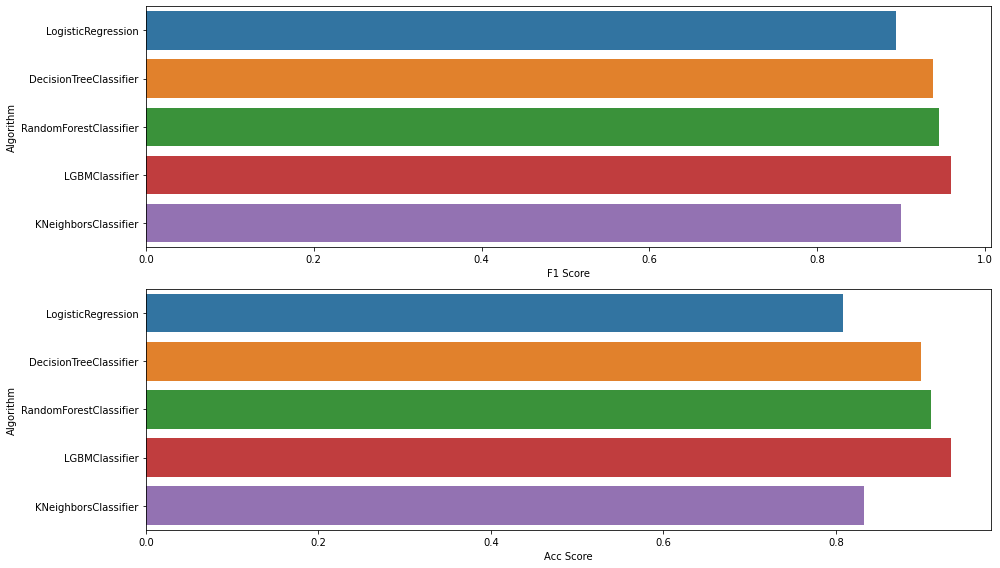

In [0]:
# ---------- Plot F1 Score and Accuracy score from Normal Data

plt.figure(figsize=(14,8))

plt.subplot(2,1,1)
sns.barplot(data=df_algo,y='Algorithm',x='F1 Score')

plt.subplot(2,1,2)
sns.barplot(data=df_algo,y='Algorithm',x='Acc Score')

plt.tight_layout()

In [0]:
# ---------- F1 Score and Accuracy from SMOTE Data Train

algo_F1Smote = []
algo_AccSmote = []

for item in algorithm:
    model = item()
    model.fit(X_train_smote,y_train_smote)
    predictions = model.predict(X_test)
    accur = accuracy_score(y_test,predictions)
    algo_AccSmote.append(accur)
    f1 = f1_score(y_test,predictions)
    algo_F1Smote.append(f1)

df_algo_smote = pd.DataFrame({
    'Algorithm' : algo_name,
    'F1 Score SMOTE' : algo_F1Smote,
    'Acc Score SMOTE' : algo_AccSmote
})

df_algo_smote

,Algorithm,F1 Score SMOTE,Acc Score SMOTE
0,LogisticRegression,0.882326,0.795040
1,DecisionTreeClassifier,0.940594,0.903950
2,RandomForestClassifier,0.949722,0.918252
3,LGBMClassifier,0.961532,0.937803
4,KNeighborsClassifier,0.859157,0.785068


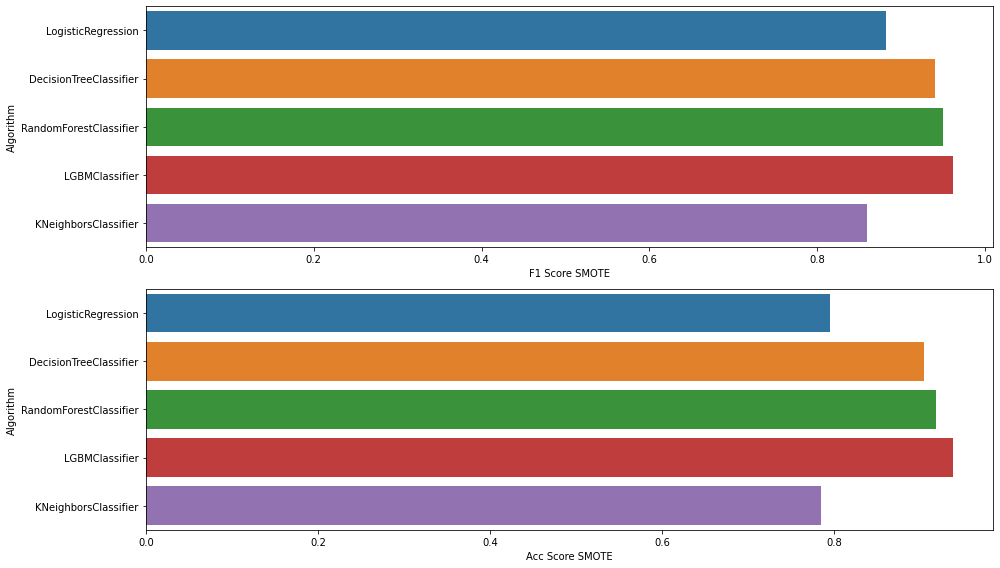

In [0]:
# ---------- Plot F1 Score and Accuracy score from SMOTE Data Train

plt.figure(figsize=(14,8))

plt.subplot(2,1,1)
sns.barplot(data=df_algo_smote,y='Algorithm',x='F1 Score SMOTE')

plt.subplot(2,1,2)
sns.barplot(data=df_algo_smote,y='Algorithm',x='Acc Score SMOTE')

plt.tight_layout()

> From all testing to each algorithm F1 Score and Accuracy Score give better result on Decision Tree, Random Forest, and LGBM. The score for both of normal data and smote data give a very close result. So, I need to check classification each of algorithms (Top 3).

# Classification Report of Normal Data and SMOTE from Top 3 Algorithms

#### 1.A.  Random Forest with Normal Data

In [0]:
# Modelling and fitting
rf = RandomForestClassifier(random_state=101)
rf.fit(X_train,y_train)

# predicting
prediction_rf = rf.predict(X_test)

# Evaluation
print(classification_report(y_test,prediction_rf))
tn, fp, fn, tp = confusion_matrix(y_test,prediction_rf).ravel()
print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1468
           1       0.94      0.97      0.95      6153

    accuracy                           0.92      7621
   macro avg       0.89      0.85      0.87      7621
weighted avg       0.92      0.92      0.92      7621

tn :  1087  fp :  381  fn :  213  tp :  5940


#### 1.B. Random Forest with SMOTE

In [0]:
# Modelling and fitting
rf_smote = RandomForestClassifier(random_state=101)
rf_smote.fit(X_train_smote,y_train_smote)

# predicting
prediction_rf_smote = rf_smote.predict(X_test)

# Evaluation
print(classification_report(y_test,prediction_rf_smote))
tn, fp, fn, tp = confusion_matrix(y_test,prediction_rf_smote).ravel()
print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)

              precision    recall  f1-score   support

           0       0.80      0.75      0.78      1468
           1       0.94      0.95      0.95      6153

    accuracy                           0.92      7621
   macro avg       0.87      0.85      0.86      7621
weighted avg       0.91      0.92      0.91      7621

tn :  1106  fp :  362  fn :  279  tp :  5874


#### 2.A. LGBM with Normal Data

In [0]:
# Modelling and fitting
lgbm = LGBMClassifier(random_state=101)
lgbm.fit(X_train,y_train)

# predicting
prediction_lgbm = lgbm.predict(X_test)

# Evaluation
print(classification_report(y_test,prediction_lgbm))
tn, fp, fn, tp = confusion_matrix(y_test,prediction_lgbm).ravel()
print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1468
           1       0.96      0.97      0.96      6153

    accuracy                           0.94      7621
   macro avg       0.91      0.90      0.90      7621
weighted avg       0.94      0.94      0.94      7621

tn :  1208  fp :  260  fn :  199  tp :  5954


#### 2.B LGBM with SMOTE

In [0]:
# Modelling and fitting
lgbm_smote = LGBMClassifier(random_state=101)
lgbm_smote.fit(X_train_smote,y_train_smote)

# predicting
prediction_lgbm_smote = lgbm_smote.predict(X_test)

# Evaluation
print(classification_report(y_test,prediction_lgbm_smote))
tn, fp, fn, tp = confusion_matrix(y_test,prediction_lgbm_smote).ravel()
print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1468
           1       0.96      0.96      0.96      6153

    accuracy                           0.94      7621
   macro avg       0.90      0.90      0.90      7621
weighted avg       0.94      0.94      0.94      7621

tn :  1223  fp :  245  fn :  229  tp :  5924


#### 3.A. Decision Tree with Normal Data

In [0]:
# Modelling and fitting
tree = DecisionTreeClassifier(random_state=101)
tree.fit(X_train,y_train)

# predicting
prediction_tree = tree.predict(X_test)

# Evaluation
print(classification_report(y_test,prediction_tree))
tn, fp, fn, tp = confusion_matrix(y_test,prediction_tree).ravel()
print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)

              precision    recall  f1-score   support

           0       0.76      0.75      0.76      1468
           1       0.94      0.94      0.94      6153

    accuracy                           0.91      7621
   macro avg       0.85      0.85      0.85      7621
weighted avg       0.91      0.91      0.91      7621

tn :  1102  fp :  366  fn :  343  tp :  5810


#### 3.B. Decision Tree with SMOTE

In [0]:
# Modelling and fitting
tree_smote = DecisionTreeClassifier(random_state=101)
tree_smote.fit(X_train_smote,y_train_smote)

# predicting
prediction_tree_smote = tree_smote.predict(X_test)

# Evaluation
print(classification_report(y_test,prediction_tree_smote))
tn, fp, fn, tp = confusion_matrix(y_test,prediction_tree_smote).ravel()
print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)

              precision    recall  f1-score   support

           0       0.75      0.74      0.74      1468
           1       0.94      0.94      0.94      6153

    accuracy                           0.90      7621
   macro avg       0.85      0.84      0.84      7621
weighted avg       0.90      0.90      0.90      7621

tn :  1082  fp :  386  fn :  355  tp :  5798


---------------------

> **From all classification report** I could say that the best data for that three algorithms is SMOTE Data. Because it gives better result on recall. (It's more important to avoid the condition when the status actually charge off and we predict as PIF). If we chose precission, we will avoid the condition that our model predict PIF as Charge off. So, recall is better than precission in this case.

---------------------

# Tuning Hyperparameter for Selected Models

Our selected models which are :
1. Decision Tree
2. LGBM
3. Random Forest

### 1. Decision Tree

In [0]:
model_1 = DecisionTreeClassifier(random_state=101)

# Hyperparameter for decision tree
param_model_1 = {
    'max_depth' : np.arange(2,12,2), 
    'min_samples_split' : [i for i in range(3,22,2)], 
    'min_samples_leaf' : [i for i in range(2,11)],
}

# Grid Search CV
### model 1a from f1 score
GSCV_model_1a = GridSearchCV(estimator=model_1,
                     param_grid=param_model_1
                     ,scoring='f1',cv=3)
### model 1b from accuracy
GSCV_model_1b = GridSearchCV(estimator=model_1,
                     param_grid=param_model_1
                     ,scoring='accuracy',cv=3)

In [0]:
# Fitting Model 1a
GSCV_model_1a.fit(X_train_smote,y_train_smote)
prediction_1a = GSCV_model_1a.predict(X_test)

# Evaluation 1a
print('=============== CLASSIFICATION REPORT SCORING FROM F1 SCORE ===============')
print(classification_report(y_test,prediction_1a))
tn, fp, fn, tp = confusion_matrix(y_test,prediction_1a).ravel()
print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)
print()
print('=============== BEST PARAMETERS SCORING FROM F1 SCORE ===============')
print(GSCV_model_1a.best_params_)

=============== CLASSIFICATION REPORT SCORING FROM F1 SCORE ===============
              precision    recall  f1-score   support

           0       0.68      0.88      0.77      1468
           1       0.97      0.90      0.93      6153

    accuracy                           0.90      7621
   macro avg       0.82      0.89      0.85      7621
weighted avg       0.91      0.90      0.90      7621

tn :  1294  fp :  174  fn :  615  tp :  5538

=============== BEST PARAMETERS SCORING FROM F1 SCORE ===============
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [0]:
# Fitting Model 1b
GSCV_model_1b.fit(X_train_smote,y_train_smote)
prediction_1b = GSCV_model_1b.predict(X_test)

# Evaluation 1b
print('=============== CLASSIFICATION REPORT SCORING FROM ACCURACY SCORE ===============')
print(classification_report(y_test,prediction_1b))
tn, fp, fn, tp = confusion_matrix(y_test,prediction_1b).ravel()
print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)
print()
print('=============== BEST PARAMETERS SCORING FROM ACCURACY SCORE ===============')
print(GSCV_model_1b.best_params_)

=============== CLASSIFICATION REPORT SCORING FROM ACCURACY SCORE ===============
              precision    recall  f1-score   support

           0       0.68      0.88      0.77      1468
           1       0.97      0.90      0.93      6153

    accuracy                           0.90      7621
   macro avg       0.82      0.89      0.85      7621
weighted avg       0.91      0.90      0.90      7621

tn :  1294  fp :  174  fn :  615  tp :  5538

=============== BEST PARAMETERS SCORING FROM ACCURACY SCORE ===============
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}


### 2. Light GBM Classifier

In [0]:
model_2 = LGBMClassifier(random_state=101)

# Hyperparameter for Light GBM Classifier
param_model_2 = {
    'max_depth' : [-1,4,5,7],
    'num_leaves' : [10,27,31,70],
    'min_data_in_leaf' : [20,60,100,200],
    'learning_rate' : [0.001,0.01],
    'num_iterations' :[200]
}

# Grid Search CV
### model 2a from f1 score
GSCV_model_2a = GridSearchCV(estimator=model_2,
                     param_grid=param_model_2
                     ,scoring='f1',cv=3)
### model 1b from accuracy
GSCV_model_2b = GridSearchCV(estimator=model_2,
                     param_grid=param_model_2
                     ,scoring='accuracy',cv=3)

In [0]:
# Fitting Model 2a
GSCV_model_2a.fit(X_train_smote,y_train_smote)
prediction_2a = GSCV_model_2a.predict(X_test)

# Evaluation 2a
print('=============== CLASSIFICATION REPORT SCORING FROM F1 SCORE ===============')
print(classification_report(y_test,prediction_2a))
tn, fp, fn, tp = confusion_matrix(y_test,prediction_2a).ravel()
print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)
print()
print('=============== BEST PARAMETERS SCORING FROM F1 SCORE ===============')
print(GSCV_model_2a.best_params_)

=============== CLASSIFICATION REPORT SCORING FROM F1 SCORE ===============
              precision    recall  f1-score   support

           0       0.78      0.87      0.83      1468
           1       0.97      0.94      0.96      6153

    accuracy                           0.93      7621
   macro avg       0.88      0.91      0.89      7621
weighted avg       0.93      0.93      0.93      7621

tn :  1283  fp :  185  fn :  355  tp :  5798

=============== BEST PARAMETERS SCORING FROM F1 SCORE ===============
{'learning_rate': 0.01, 'max_depth': -1, 'min_data_in_leaf': 60, 'num_iterations': 200, 'num_leaves': 70}


In [0]:
# Fitting Model 2a
GSCV_model_2b.fit(X_train_smote,y_train_smote)
prediction_2b = GSCV_model_2b.predict(X_test)

# Evaluation 2a
print('=============== CLASSIFICATION REPORT SCORING FROM F1 SCORE ===============')
print(classification_report(y_test,prediction_2a))
tn, fp, fn, tp = confusion_matrix(y_test,prediction_2a).ravel()
print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)
print()
print('=============== BEST PARAMETERS SCORING FROM F1 SCORE ===============')
print(GSCV_model_2a.best_params_)

=============== CLASSIFICATION REPORT SCORING FROM F1 SCORE ===============
              precision    recall  f1-score   support

           0       0.78      0.87      0.83      1468
           1       0.97      0.94      0.96      6153

    accuracy                           0.93      7621
   macro avg       0.88      0.91      0.89      7621
weighted avg       0.93      0.93      0.93      7621

tn :  1283  fp :  185  fn :  355  tp :  5798

=============== BEST PARAMETERS SCORING FROM F1 SCORE ===============
{'learning_rate': 0.01, 'max_depth': -1, 'min_data_in_leaf': 60, 'num_iterations': 200, 'num_leaves': 70}


##### 2.1 LGBM 2C (Others Parameters Value)

In [0]:
model_2c = LGBMClassifier(random_state=101)

# Hyperparameter for Light GBM Classifier
param_model_2c = {
    'max_depth' : [-1,7,12],
    'num_leaves' : [31,70,100,120,1000],
    'min_data_in_leaf' : [20,60,100],
    'learning_rate' : [0.0001,0.001,0.01],
    'num_iterations' :[200,400,600]
}

# Grid Search CV
### model 2c from f1 score
GSCV_model_2c = GridSearchCV(estimator=model_2c,
                     param_grid=param_model_2c
                     ,scoring='f1',cv=3)

In [0]:
# Fitting Model 2c
GSCV_model_2c.fit(X_train_smote,y_train_smote)
prediction_2c = GSCV_model_2c.predict(X_test)

# Evaluation 2a
print('=============== CLASSIFICATION REPORT SCORING FROM F1 SCORE ===============')
print(classification_report(y_test,prediction_2c))
tn, fp, fn, tp = confusion_matrix(y_test,prediction_2c).ravel()
print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)
print()
print('=============== BEST PARAMETERS SCORING FROM F1 SCORE ===============')
print(GSCV_model_2c.best_params_)

=============== CLASSIFICATION REPORT SCORING FROM F1 SCORE ===============
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1468
           1       0.96      0.95      0.96      6153

    accuracy                           0.93      7621
   macro avg       0.89      0.90      0.89      7621
weighted avg       0.93      0.93      0.93      7621

tn :  1242  fp :  226  fn :  283  tp :  5870

=============== BEST PARAMETERS SCORING FROM F1 SCORE ===============
{'learning_rate': 0.01, 'max_depth': 12, 'min_data_in_leaf': 100, 'num_iterations': 400, 'num_leaves': 31}


### 3. Random Forest

In [0]:
model_3 = RandomForestClassifier(random_state=101)

# Hyperparameter for RandomForest
param_model_3 = {
    'n_estimators' : [100,150,200],
    'max_depth' : np.arange(4,14,2),
    'min_samples_split' : [i for i in range(3,17,2)],
    'min_samples_leaf' : [i for i in range(2,6)],
    'bootstrap' : [True,False]
}

# Grid Search CV
### model 3 from f1 score
GSCV_model_3 = GridSearchCV(estimator=model_3,
                     param_grid=param_model_3
                     ,scoring='f1',cv=3)

# Fitting Model 3
GSCV_model_3.fit(X_train_smote,y_train_smote)
prediction_3 = GSCV_model_3.predict(X_test)

# Evaluate
print('=============== CLASSIFICATION REPORT SCORING FROM F1 SCORE ===============')
print(classification_report(y_test,prediction_3))
tn, fp, fn, tp = confusion_matrix(y_test,prediction_3).ravel()
print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)
print()
print('=============== BEST PARAMETERS SCORING FROM F1 SCORE ===============')
print(GSCV_model_3.best_params_)

=============== CLASSIFICATION REPORT SCORING FROM F1 SCORE ===============
              precision    recall  f1-score   support

           0       0.72      0.79      0.76      1468
           1       0.95      0.93      0.94      6153

    accuracy                           0.90      7621
   macro avg       0.84      0.86      0.85      7621
weighted avg       0.91      0.90      0.90      7621

tn :  1166  fp :  302  fn :  449  tp :  5704

=============== BEST PARAMETERS SCORING FROM F1 SCORE ===============
{'bootstrap': False, 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 150}


--------------------------

> **From all of this I could conclude that LGBM Classifier is the best algorithm for my machine learning model. So, I will try once again to tuning hyperparameter for our best algorithm (LGBM Classifier) before I decide to use it.**

---------------------------

# Tuning Hyperparameter Light GBM Classifier

In [0]:
model_lgbm = LGBMClassifier(random_state=101)

# Hyperparameter for Light GBM Classifier
param_model_lgbm = {
    'max_depth' : [10,12,14,16],
    'num_leaves' : [20,31,70,100],
    'min_data_in_leaf' : [100,120,150],
    'learning_rate' : [0.005,0.01,0.05],
    'num_iterations' :[600,800,1000]
}

# Grid Search CV
### model lgbm from f1 score
GSCV_model_lgbm = GridSearchCV(estimator=model_lgbm,
                     param_grid=param_model_lgbm
                     ,scoring='f1',cv=3)

# Fitting Model lgbm
GSCV_model_lgbm.fit(X_train_smote,y_train_smote)
prediction_lgbm = GSCV_model_lgbm.predict(X_test)

# Evaluation lgbm
print('=============== CLASSIFICATION REPORT SCORING FROM F1 SCORE ===============')
print(classification_report(y_test,prediction_lgbm))
tn, fp, fn, tp = confusion_matrix(y_test,prediction_lgbm).ravel()
print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)
print()
print('=============== BEST PARAMETERS SCORING FROM F1 SCORE ===============')
print(GSCV_model_lgbm.best_params_)

=============== CLASSIFICATION REPORT SCORING FROM F1 SCORE ===============
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1468
           1       0.96      0.95      0.96      6153

    accuracy                           0.93      7621
   macro avg       0.89      0.90      0.90      7621
weighted avg       0.94      0.93      0.93      7621

tn :  1247  fp :  221  fn :  283  tp :  5870

=============== BEST PARAMETERS SCORING FROM F1 SCORE ===============
{'learning_rate': 0.005, 'max_depth': 14, 'min_data_in_leaf': 120, 'num_iterations': 800, 'num_leaves': 31}


-----------------------

**Conclusion for LGBM Method :** After tuning hyperparameter LGBM again, we could see it show better result on precission but lower at recall. Because we want to minimize the condition that CHGOFF predicted as PIF, so we need to increase recall 0 (CHGOFF) and precission 1 (PIF). So, the best LGBM Classifier hyperparameter comes from first tuning which has recall 0 87% and PIF 1 97%, and it has acceptable result in others metrics. **The hyperparameter is :**`{'learning_rate': 0.01, 'max_depth': -1, 'min_data_in_leaf': 60, 'num_iterations': 200, 'num_leaves': 70}`

-----------------------

# Principal Component Analysis

To make greater exploration machine learning processing, in this section I will try to use PCA. But before doing PCA, I will do StandardScaler to standardize the data which could make it better when we put it to PCA. Then, I will use Machine Learning which is LGBM with best hyperparameter.

> I will use X_train and y_train from SMOTE, and using original X_test and y_test

Text(0, 0.5, 'F1 scores')

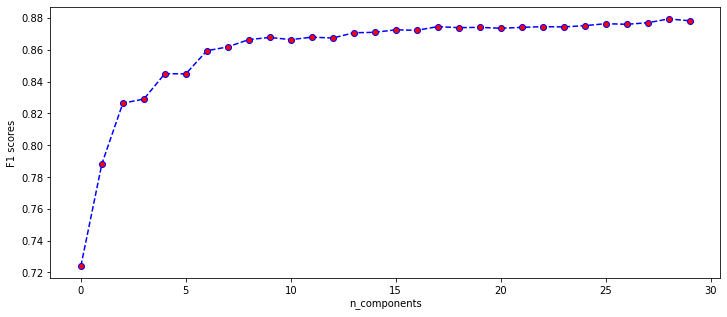

In [0]:
# ------ Library StandarScaler
from sklearn.preprocessing import StandardScaler

# ------ Standard Scaler
scaler = StandardScaler()
## Fit Scaler for Train
scaled_Xtrain = scaler.fit_transform(X_train_smote)
## Fit Sclaer for Test Data
scaled_Xtest = scaler.transform(X_test)

# ------ Library PCA
from sklearn.decomposition import PCA

F1_score = []

# ------- Check Learning Curve to The Best n_components
for i in range(1,31):
    pca = PCA(n_components=i,random_state=101)
    X_pca = pca.fit_transform(scaled_Xtrain)
    model = LGBMClassifier(random_state=101,learning_rate=0.01,max_depth=-1,min_data_in_leaf=60,num_iterations=200,num_leaves=70)
    cv_mean = cross_val_score(model,X_pca,y_train_smote,cv=3,scoring='f1').mean()
    F1_score.append(cv_mean)

# -------- Plot Graph n_components vs F1 Score
plt.figure(figsize=(12,5))
plt.plot(F1_score, color='blue', marker='o',markerfacecolor='red',linestyle='dashed')
plt.xlabel('n_components')
plt.ylabel('F1 scores')

> From this result, we could see that **the best n_component is 8**. So, we will use this as parameter for modelling with PCA.

In [0]:
# Doing PCA
pca = PCA(n_components=8,random_state=101)
pca_Xtrain = pca.fit_transform(scaled_Xtrain)
pca_Xtest = pca.transform(scaled_Xtest)

# Modelling with LGBM
model_pca = LGBMClassifier(random_state=101,learning_rate=0.01,max_depth=-1,min_data_in_leaf=60,num_iterations=200,num_leaves=70)
model_pca.fit(pca_Xtrain,y_train_smote)
prediction_pca = model_pca.predict(pca_Xtest)
print('=============== CLASSIFICATION REPORT PCA ===============')
print(classification_report(y_test,prediction_pca))

=============== CLASSIFICATION REPORT PCA ===============
              precision    recall  f1-score   support

           0       0.48      0.63      0.55      1468
           1       0.91      0.84      0.87      6153

    accuracy                           0.80      7621
   macro avg       0.69      0.74      0.71      7621
weighted avg       0.82      0.80      0.81      7621



# Conclusion for Machine Learning
After all method that I have tried to find the best model to predict SBA Loan Dataset, the best machine learning model still **Light GBM Classifier with hyperparameter :** `{'learning_rate': 0.01, 'max_depth': -1, 'min_data_in_leaf': 60, 'num_iterations': 200, 'num_leaves': 70}`

**The final model could we see in the following below :**

In [0]:
# ------- Final Model
LGBM_Model = LGBMClassifier(random_state=101,learning_rate=0.01,max_depth=-1,min_data_in_leaf=60,num_iterations=200,num_leaves=70)
LGBM_Model.fit(X_train_smote,y_train_smote)
PredictionLGBM = LGBM_Model.predict(X_test)
print('=============== CLASSIFICATION REPORT ===============')
print(classification_report(y_test,PredictionLGBM))

=============== CLASSIFICATION REPORT ===============
              precision    recall  f1-score   support

           0       0.78      0.87      0.83      1468
           1       0.97      0.94      0.96      6153

    accuracy                           0.93      7621
   macro avg       0.88      0.91      0.89      7621
weighted avg       0.93      0.93      0.93      7621



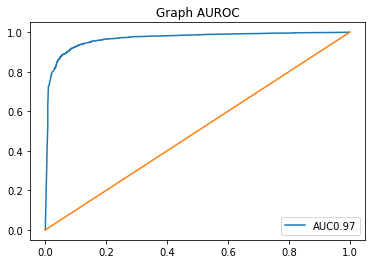

In [0]:
# -------- AUC-ROC Curve
pred_proba = LGBM_Model.predict_proba(X_test)
prediction_AUC = pred_proba[:,1]

FPR, TPR, Threshold = roc_curve(y_test,prediction_AUC)
roc_auc = auc(FPR,TPR)

# Plot
plt.plot(FPR,TPR,label=f'AUC{round(roc_auc,2)}')
plt.plot([0,1],[0,1])
plt.title('Graph AUROC')
plt.legend()

In [0]:
df_input = df[(df['State'] != 'AZ') | (df['State'] != 'KS') | #Yellow Zone
              (df['State'] != 'ND') | (df['State'] != 'WY') | #Red Zone
              (df['State'] != 'GA') | (df['State'] != 'FL')].sample(30000,random_state=101)  #Darkgreen Zone

# Features Target
newdata_features = df_input.drop(['State','ApprovalFY','MIS_Status'],axis=1)
newdata_true_label = df_input['MIS_Status']

# Prediction
prediction_newdata = LGBM_Model.predict(newdata_features)

# Evaluation
print('=============== CLASSIFICATION REPORT SCORING FROM F1 SCORE ===============')
print(classification_report(newdata_true_label,prediction_newdata))
tn, fp, fn, tp = confusion_matrix(newdata_true_label,prediction_newdata).ravel()
print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)
print()

=============== CLASSIFICATION REPORT SCORING FROM F1 SCORE ===============
              precision    recall  f1-score   support

           0       0.62      0.87      0.72      4826
           1       0.97      0.90      0.93     25174

    accuracy                           0.89     30000
   macro avg       0.79      0.88      0.83     30000
weighted avg       0.92      0.89      0.90     30000

tn :  4204  fp :  622  fn :  2617  tp :  22557

